# Easy Synchronous Control Loop

Demonstration of synchronous methods for the Sidekick Facility

## External Modules

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import time
import datetime
from time import sleep

import pvaccess as pva

## Generic Helper Fuctions

#### Timer decorator
Code modified from https://dev.to/kcdchennai/python-decorator-to-measure-execution-time-54hk

In [6]:
from functools import wraps
import time

def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        #print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        print(f'Function {func.__name__} took {total_time:.4f} seconds')
        return result
    return timeit_wrapper

## Configure Sidekick Facility Settings

Set timing settings and rep-rate.

In [75]:
proton_dt = pva.Channel("PROTON:dt:set", pva.CA)
electron_dt = pva.Channel("ELECTRON:dt:set", pva.CA)
laser_dt = pva.Channel("LASER:powers:dt:set", pva.CA)
pulse_rep = pva.Channel("PULSEGEN:reprate:set", pva.CA)

proton_dt.put(5.0e-6) # seconds
electron_dt.put(5.0e-6) # seconds
laser_dt.put(5) # microseconds
pulse_rep.put(50) # Hz

## Define Synchronous Acquisition Channels and Methods

### EPICS Channels for the Sidekick Facility (PVAccess and Channel Access)

In [48]:
powers_set_CA= pva.Channel("LASER:powers:set", pva.CA)
powers_RBV_CA = pva.Channel("LASER:powers", pva.CA) # readback value
powers_RBV_PROC_CA = pva.Channel("LASER:powers.PROC", pva.CA) # force readback value record to process
etrace_PVA = pva.Channel("ELECTRON-DAQ:trace", pva.PVA)
ptrace_PVA = pva.Channel("PROTON-DAQ:trace", pva.PVA)
etrig_CA = pva.Channel("ELECTRON:trigger:count", pva.CA)
etrig_PROC_CA = pva.Channel("ELECTRON:trigger:count.PROC", pva.CA)

### Synchronous Methods tailored to the Sidekick System
These methods make use of the above channels.

In [74]:
def synchronous_goto_setpoint(setpoint, setter_CA, getter_CA, getter_PROC_CA, sleep_secs=0.01):
    """ Set channel and then block until the readback channel's value (scalar array) exactly matches the setpoint value (scalar array) """
    assert(isinstance(setpoint, np.ndarray))
    assert(isinstance(setter_CA, pva.pvaccess.Channel))
    assert(isinstance(getter_CA, pva.pvaccess.Channel))
    assert(isinstance(getter_PROC_CA, pva.pvaccess.Channel))
    assert(getter_PROC_CA.getName().endswith(".PROC"))
           
    setter_CA.putScalarArray(list(setpoint))
    while not np.array_equal(setter_CA.get().getScalarArray(), getter_CA.get().getScalarArray()): # compare our setpoint with our RBV
        getter_PROC_CA.put(1) # force immediate processing of the readback value record
        sleep(sleep_secs) # delay a moment before requesting another check
        
def get_synchronous_trigger_count(trig_CA, trig_PROC_CA):
    """Get the current trigger count from a device, forcing completed processing of the request before retrieval of the value"""    
    trig_PROC_CA.put(1) # force processing
    while trig_PROC_CA.get().get()['value'] == '\x01':  # ensure value is done being processed
        sleep(0.001)
    return np.int64(trig_CA.get().get()['value']) # get the most up-to-date trigger count

@timeit
def realpulse(pulse, reps=1, powers_set_CA=powers_set_CA, powers_RBV_CA=powers_RBV_CA, 
                powers_RBV_PROC_CA=powers_RBV_PROC_CA, etrace_PVA=etrace_PVA, 
                ptrace_PVA=ptrace_PVA, trig_CA=etrig_CA, trig_PROC_CA=etrig_PROC_CA):
    """ Synchronously set a laser pulse profile and record the proton and electron response
    Inputs:
        pulse   1D NumPy Double array of 100 points - the desired pulse, from 0 to 255
        reps     How many repetitions of the data to acquire?
        powers_set_CA   Channel object referring to 'LASER:powers:set' (Channel Access)
        powers_RBV_CA   Channel object referring to 'LASER:powers' (Channel Access)
        powers_RBV_PROC_CA Channel object referring to 'LASER:powers.PROC' (Channel Access - allows us to initiate PV processing)
        etrace_PVA     Channel object referring to 'ELECTRON-DAQ:trace' (PVAccess)
        ptrace_PVA     Channel object referring to 'ELECTRON-DAQ:trace' (PVAccess)
        trig_CA        Channel object referring to an official source of truth on the global trigger count (Channel Access)
        trig_PROC_CA     Channel object referring to the ".PROC" field of an official source of truth on the global trigger count (Channel Access)
    """

    # Data validity checks
    assert(isinstance(pulse, np.ndarray))
    assert(np.ndim(pulse) == 1)
    assert(len(pulse) == 100)
    assert(np.max(pulse) <= 255)
    assert(np.min(pulse) >= 0)
    if (np.count_nonzero(pulse - pulse.round() > 0)):
        raise Exception("Pulse array contains fractional values (should be only integers, from 0 to 255).")

    # Data type conversion to uint8
    pulse_uint8 = np.uint8(pulse)

    # Set the pulse values (blocking) and establish a minimum global shot count
    synchronous_goto_setpoint(setpoint=pulse_uint8, setter_CA=powers_set_CA, getter_CA=powers_RBV_CA, getter_PROC_CA=powers_RBV_PROC_CA)
    minimum_shot_ID = 1 + get_synchronous_trigger_count(trig_CA, trig_PROC_CA)
    
    ## Begin a quick little asynchronous acquisition that matches the number of acquisitions we need
    electrons = np.zeros((reps, len(pulse)), dtype=np.int64)
    protons = np.zeros_like(electrons)
    i_elec = 0
    i_prot = 0
    alldone_prot = False
    alldone_elec = False
    
    def process_etrace(pvobj):
        nonlocal i_elec, alldone_elec
        nonlocal electrons
        
        if pvobj["uniqueId"] >= minimum_shot_ID:
            if i_elec < reps:
                electrons[i_elec,:] = pvobj.get()['value'][0]['ushortValue']
                i_elec += 1
            else:
                alldone_elec = True

    def process_ptrace(pvobj):
        nonlocal i_prot, alldone_prot
        nonlocal protons
        if pvobj["uniqueId"] >= minimum_shot_ID:
            if i_prot < reps:
                protons[i_prot,:] = pvobj.get()['value'][0]['ushortValue']
                i_prot += 1
            else:
                alldone_prot = True

    etrace_PVA.monitor(process_etrace, 'field(value,uniqueId,timeStamp)')
    ptrace_PVA.monitor(process_ptrace, 'field(value,uniqueId,timeStamp)')

    while not (alldone_prot and alldone_prot):
        sleep(0.001)

    etrace_PVA.stopMonitor()
    ptrace_PVA.stopMonitor()
    
    return np.squeeze(electrons), np.squeeze(protons), pulse_uint8

## Single repetition test

Function realpulse took 0.0858 seconds
Function realpulse took 0.0759 seconds


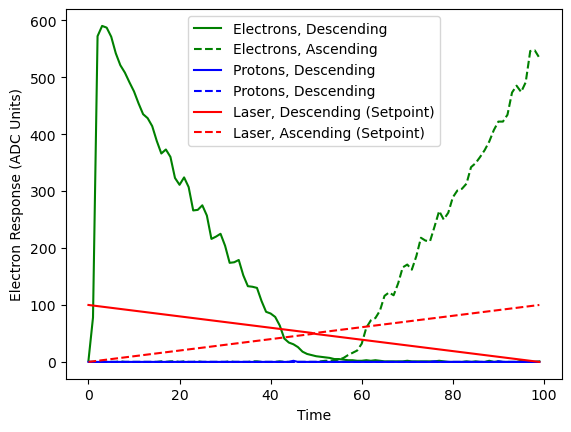

In [88]:
# test pulse 
pulse_descent = np.round(np.linspace(1, 0, 100)*100)
pulse_ascent = np.round(np.linspace(0, 1, 100)*100)
elecs1, prots1, pulse1 = realpulse(pulse_descent)
elecs2, prots2, pulse2 = realpulse(pulse_ascent)

plt.plot(elecs1, label="Electrons, Descending", c='g')
plt.plot(elecs2, '--', label="Electrons, Ascending", c='g')
plt.plot(prots1, label="Protons, Descending", c='b')
plt.plot(prots2, '--', label="Protons, Descending", c='b')
plt.plot(pulse1, label="Laser, Descending (Setpoint)", c='r')
plt.plot(pulse2, '--', label="Laser, Ascending (Setpoint)", c='r')
plt.ylabel("Electron Response (ADC Units)")
plt.xlabel("Time")
plt.legend()

## Multiple repetition test

Function realpulse took 0.2583 seconds
Function realpulse took 0.2572 seconds


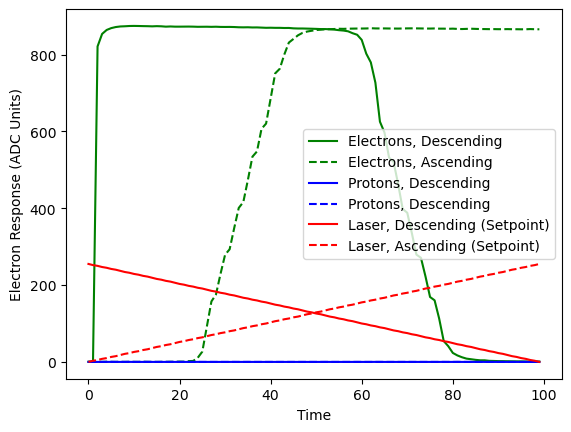

In [87]:
# test pulse 
pulse_descent = np.round(np.linspace(1, 0, 100)*255)
pulse_ascent = np.round(np.linspace(0, 1, 100)*255)
elecs1, prots1, pulse1 = realpulse(pulse_descent, reps=10)
elecs2, prots2, pulse2 = realpulse(pulse_ascent, reps=10)

plt.plot(np.mean(elecs1, axis=0), label="Electrons, Descending", c='g')
plt.plot(np.mean(elecs2, axis=0), '--', label="Electrons, Ascending", c='g')
plt.plot(np.mean(prots1, axis=0), label="Protons, Descending", c='b')
plt.plot(np.mean(prots2, axis=0), '--', label="Protons, Descending", c='b')
plt.plot(pulse1, label="Laser, Descending (Setpoint)", c='r')
plt.plot(pulse2, '--', label="Laser, Ascending (Setpoint)", c='r')
plt.ylabel("Electron Response (ADC Units)")
plt.xlabel("Time")
plt.legend()